In [1]:
from brian2 import *
from util.visualization_functions import *
from util.analysis_functions import *
import brian2.numpy_ as np
from networkx import nx
%matplotlib inline

# set_device('cpp_standalone', clean=True) # for C++ speedup
# prefs.devices.cpp_standalone.openmp_threads = 4 # number of threads; needs openmp

In [2]:
# recreate the simulation used in Ocker 2015, adding inhibitory neurons

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2                # leak conductance
vL = -72 * mV                              # leak reversal potential
C = 1 * ufarad * cm**-2                    # membrane capacitance
delta = 1.4 * mV                           # action potential steepness
vT = -48 * mV                              # action potential initiation threshold
mu = 1 * uamp * cm**-2                     # noise mean
sigma = 9 * mV                             # noise std dev
tau_s = 5 * ms                             # synaptic time constant
           
# other cell params           
vTh = 30 * mV                              # spike threshold
vR = -72 * mV                              # reset potential
tRef = 2 * ms                              # action potential width (refractory time)
           
# network params           
p = 0.15                                   # connection density
N_exc = 666                                # number exc neurons
N_inh = 334                                # number inh neurons
N_network = N_exc + N_inh                  # number of neurons

# simulation params
sim_time_ms = 1000 * 60 * 5                # simulation time in ms
monitor_dt_ms = sim_time_ms / 100          # timestep for monitor evaluation

######################
#                    #
#   init the model   #
#                    #
######################
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi) + j_e + j_i) / C : volt (unless refractory)
dj_e/dt = -j_e/tau_s : amp * meter ** -2
dj_i/dt = -j_i/tau_s : amp * meter ** -2
'''

neurons = NeuronGroup(N_network, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

neurons_exc = neurons[:N_exc]
neurons_inh = neurons[N_exc:(N_exc + N_inh - 1)]

synapses_exc = Synapses(neurons_exc, neurons,
                    '''w : amp * meter**-2
                        dApre/dt = -Apre / tauPre : amp * meter**-2 (event-driven)
                        dApost/dt = -Apost / tauPost : amp * meter**-2 (event-driven)''',
                    on_pre='''j_e += w
                        Apre += dApre / (N_network*p)
                        w = clip(w + Apost, 0, wMax)''',
                    on_post='''Apost += dApost / (N_network*p)
                        w = clip(w + Apre, 0, wMax)''')

synapses_inh = Synapses(neurons_inh, neurons,
                       '''w : amp * meter**-2''',
                       on_pre='''j_i += w''')
           
# connect synapses
synapses_exc.connect(condition='i!=j', p=p)
synapses_inh.connect(condition='i!=j', p=p)

# get connection density (for use in STDP params)
p0 = p #compute_p0(neurons, synapses)

# stdp params
wMax = 5 * uamp * cm**-2            # max syn weight
tauPre = 5 * ms #15 * ms            # synaptic time constant
tauPost = 5 * ms #2 * tauPre        # synaptic time constant
dApre = .01
dApost = -dApre * tauPre / tauPost * 1.05
dApost *= wMax
dApre *= wMax

# assign synaptic weights
mu_w0 = wMax * 2 / (p0 * N_network)
sigma_w0 = mu_w0 / 10
synapses_exc.w = "mu_w0 + (0.5 - rand()) * sigma_w0"
synapses_inh.w = "mu_w0 + (0.5 - rand()) * sigma_w0"

# monitors
sp_mon_exc = SpikeMonitor(neurons_exc)
sp_mon_inh = SpikeMonitor(neurons_inh)
w_mon_exc = StateMonitor(synapses_exc, 'w', record=range(len(synapses_exc.w)), dt=monitor_dt_ms * ms)
w_mon_inh = StateMonitor(synapses_inh, 'w', record=range(len(synapses_inh.w)), dt=monitor_dt_ms * ms)

# initial voltage values
for i in range(N_network):
    neurons[i].v = (np.random.normal(0, 1) * (vTh-vR))

######################
#                    #
#   run simulation   #
#                    #
######################
run(sim_time_ms * ms, report='text')





Starting simulation at t=0. s for a duration of 300. s
3.0607 s (1%) simulated in 10s, estimated 16m 10s remaining.
6.3241 s (2%) simulated in 20s, estimated 15m 29s remaining.
9.9163 s (3%) simulated in 30s, estimated 14m 38s remaining.
13.5821 s (4%) simulated in 40s, estimated 14m 4s remaining.
17.4684 s (5%) simulated in 50s, estimated 13m 29s remaining.
21.432 s (7%) simulated in 1m 0s, estimated 13m 0s remaining.
25.5084 s (8%) simulated in 1m 10s, estimated 12m 33s remaining.
29.6067 s (9%) simulated in 1m 20s, estimated 12m 11s remaining.
33.9415 s (11%) simulated in 1m 30s, estimated 11m 46s remaining.
38.5241 s (12%) simulated in 1m 40s, estimated 11m 19s remaining.
43.2692 s (14%) simulated in 1m 50s, estimated 10m 53s remaining.
48.1881 s (16%) simulated in 2m 0s, estimated 10m 27s remaining.
53.2192 s (17%) simulated in 2m 10s, estimated 10m 3s remaining.
58.1303 s (19%) simulated in 2m 20s, estimated 9m 43s remaining.
63.0499 s (21%) simulated in 2m 30s, estimated 9m 24s 

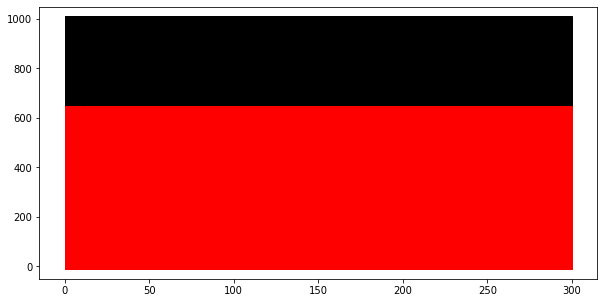

In [7]:
# spike trains
plt.figure(figsize=(10, 5))
plot(sp_mon_exc.t/second, sp_mon_exc.i, '|r')
plot(sp_mon_inh.t/second, sp_mon_inh.i + N_exc, '|k')
plt.show()

In [ ]:
def get_motif_stats_in_time2(w_mon_exc, w_mon_inh, synapses_exc, synapses_inh, N_exc, N_inh):
    """
    Computes motif statistics at 
    Args:
        w_mon (StateMonitor): Brian2 synaptic weight monitor
        synapses (Synapses): Brian2 synapses in network
        N (int): number of neurons
    Returns:
        motif_stats_mat (len(w_mon.t) x 5): matrix of motif_stats
    """
    N = N_exc + N_inh
    W = np.zeros((N, N, len(w_mon_exc.t)))
    W[synapses_exc.i[:], synapses_exc.j[:], :] = w_mon.w[:,:]

    motif_stats_mat = np.zeros((len(w_mon.t), 5))

    for i in range(len(w_mon_exc.t)):
        motif_stats_mat[i,:] = compute_motif_stats_from_matrix(W[:,:,i], N)

    return motif_stats_mat

def plot_motif_dynamics2(w_mon_exc, w_mon_inh, synapses_exc, synapses_inh, N, save_fig=False):
    """
    Plot motif dynamics a la figure 7 from Ocker et al 2015
    Args:
        w_mon (StateMonitor): Brian2 synaptic weight monitor
        synapses (Synapses): Brian2 synapses in network
        N (int): number of neurons
        save_fig (bool): optional flag to output figure image
    """
    motif_names = ["p", "q_div", "q_con", "q_ch", "q_rec"]
    motif_stats_mat = get_motif_stats_in_time2(w_mon, synapses, N)

    fig, axes = plt.subplots(5, figsize=(5, 10))

    plt.xlabel("Time (s)")
    fig.suptitle("Motif dynamics: N=" + str(N))
    for i in range(5):
        ax = axes[i]
        ax.plot(w_mon.t, motif_stats_mat[:, i])
        ax.set_ylabel(motif_names[i])

    if not save_fig:
        return

    now = str(time.time())
    name = "results/motifs_N=" + str(N) + "_t=" + str(w_mon.t[-1]) + "_" + now + ".png"
    plt.savefig(name, dpi=300, bbox_inches='tight')

In [ ]:
# figure 7
plot_motif_dynamics(w_mon, synapses, N_network, True)